# Linear models, loss functions, gradients, SGD
(c) Deniz Yuret, 2018

* Objectives: Define, train and visualize a simple model; understand gradients and SGD; learn to use the GPU.
* Prerequisites: [Callable objects](https://docs.julialang.org/en/v1/manual/methods/#Function-like-objects-1), MNIST data (02.mnist.ipynb)
* AutoGrad: Param, @diff, grad, value (used and explained)
* Knet: accuracy, zeroone, nll, train! (defined and explained)
* Knet: gpu, KnetArray (used and explained)
* Knet: dir, minibatch (used by mnist.jl)
* Knet: load, save (used by the experiment)

In [1]:
using Pkg
for p in ("Knet","AutoGrad","Plots","Images","ImageMagick","ProgressMeter")
    haskey(Pkg.installed(),p) || Pkg.add(p)
end

In [2]:
# Load data (see 02.mnist.ipynb)
using Knet: Knet, minibatch
include(Knet.dir("data","mnist.jl"))
dtrn,dtst = mnistdata(xsize=(784,:),xtype=Array{Float32});

┌ Info: Loading MNIST...
└ @ Main /data/scratch/deniz/.julia/dev/Knet/data/mnist.jl:33


## Define linear model

In [3]:
# We will use a callable object to define our linear model 
struct Linear; w; b; end
(model::Linear)(x) = model.w * x .+ model.b

## Prediction and accuracy

In [4]:
# Let's take the first minibatch from the test set
x,y = first(dtst)
summary.((x,y))

("784×100 Array{Float32,2}", "100-element Array{UInt8,1}")

In [5]:
# Initialize a random Linear model
model = Linear(randn(10,784)*0.01, zeros(10))

Linear([0.016079 0.00960136 … -0.00010056 -0.0016096; -0.0160443 -0.00481384 … -0.0121004 0.0103001; … ; 0.0113446 0.00284852 … 0.0105883 0.0199105; -0.0221949 -0.00247983 … 0.000760455 0.00106969], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [6]:
# Display its prediction on the first minibatch: a 10xN score matrix
ENV["COLUMNS"]=72
ypred = model(x)

10×100 Array{Float64,2}:
 -0.0481781   -0.0613915   -0.0278903  …  -0.0533087  -0.038898  
 -0.0433673   -0.0412378    0.0445091     -0.0794227  -0.025988  
 -0.053404     0.0461177   -0.0110039     -0.0376427  -0.150628  
 -0.0524552    0.00113356  -0.12689       -0.109012   -0.0642798 
  0.0125886    0.055526     0.0438404     -0.15614    -0.0924425 
  0.0433911   -0.144614     0.090536   …  -0.0349843  -0.11678   
  0.0495926   -0.00548649   0.0449329     -0.0884027  -0.0541504 
 -0.00961112  -0.228826    -0.0820937     -0.050206   -0.148123  
 -0.0422811    0.0493794    0.0630782     -0.0237499   0.076337  
  0.127113    -0.113545     0.0036339     -0.104526   -0.00280965

In [7]:
# correct answers are given as an array of integers
y'

1×100 LinearAlgebra.Adjoint{UInt8,Array{UInt8,1}}:
 0x07  0x02  0x01  0x0a  0x04  0x01  …  0x04  0x01  0x07  0x06  0x09

In [8]:
# We can calculate the accuracy of our model for the first minibatch
using Statistics
accuracy(model,x,y) = mean(y' .== map(i->i[1], findmax(Array(model(x)),dims=1)[2]))
accuracy(model,x,y)

0.16

In [9]:
# We can calculate the accuracy of our model for the whole test set
using Knet: Data  # type of dtrn and dtst
accuracy(model,data::Data) = mean(accuracy(model,x,y) for (x,y) in data)
accuracy(model,dtst)

0.10439999999999994

In [10]:
# ZeroOne loss (or error) is defined as 1 - accuracy
zeroone(x...) = 1 - accuracy(x...)
zeroone(model,dtst)

0.8956000000000001

## Negative log likelihood

In [11]:
# Negative log likelihood (aka cross entropy, softmax loss, NLL)
function nll(model, x, y)
    scores = model(x)
    expscores = exp.(scores)
    probabilities = expscores ./ sum(expscores, dims=1)
    answerprobs = (probabilities[y[i],i] for i in 1:length(y))
    mean(-log.(answerprobs))
end

nll (generic function with 1 method)

In [12]:
# Calculate NLL of our model for the first minibatch
nll(model,x,y)

2.287978683196233

In [13]:
# per-instance average negative log likelihood for the whole test set
nll(model,data::Data) = mean(nll(model,x,y) for (x,y) in data)
nll(model,dtst)

2.3074978217929423

## Calculating the gradient using AutoGrad

In [14]:
using AutoGrad
@doc AutoGrad

Usage:

```
x = Param([1,2,3])          # user declares parameters
x => P([1,2,3])             # they are wrapped in a struct
value(x) => [1,2,3]         # we can get the original value
sum(abs2,x) => 14           # they act like regular values outside of differentiation
y = @diff sum(abs2,x)       # if you want the gradients
y => T(14)                  # you get another struct
value(y) => 14              # which represents the same value
grad(y,x) => [2,4,6]        # but also contains gradients for all Params
```

`Param(x)` returns a struct that acts like `x` but marks it as a parameter you want to compute gradients with respect to.

`@diff expr` evaluates an expression and returns a struct that contains its value (which should be a scalar) and gradient information.

`grad(y, x)` returns the gradient of `y` (output by @diff) with respect to any parameter `x::Param`, or  `nothing` if the gradient is 0.

`value(x)` returns the value associated with `x` if `x` is a `Param` or the output of `@diff`, otherwise returns `x`.

`params(x)` returns an array of Params found by a recursive search of object `x`.

Alternative usage:

```
x = [1 2 3]
f(x) = sum(abs2, x)
f(x) => 14
grad(f)(x) => [2 4 6]
gradloss(f)(x) => ([2 4 6], 14)
```

Given a scalar valued function `f`, `grad(f,argnum=1)` returns another function `g` which takes the same inputs as `f` and returns the gradient of the output with respect to the argnum'th argument. `gradloss` is similar except the resulting function also returns f's output.


In [15]:
using Random
Random.seed!(9);

In [16]:
# To compute gradients we need to mark fields of f as Params:
model = Linear(Param(randn(10,784)), Param(zeros(10)))

Linear(P([-1.03324 -1.63236 … 0.189635 0.970502; -0.326885 -1.2965 … 1.59341 -1.53074; … ; 1.46373 -0.3455 … 0.640844 -1.3933; 0.543352 -1.17176 … -0.149665 -0.637407]), P([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))

In [17]:
# We can still do predictions with f and calculate loss:
nll(model,x,y)

19.10423456298375

In [18]:
# And we can do the same loss calculation also computing gradients:
J = @diff nll(model,x,y)

T(19.1042)

In [19]:
# To get the actual loss value from J:
value(J)

19.104234562983752

In [20]:
# To get the gradient of a parameter from J:
∇w = grad(J,model.w)

10×784 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0

In [21]:
# Note that each gradient has the same size and shape as the corresponding parameter:
∇b = grad(J,model.b)

10-element Array{Float64,1}:
 -0.139953709231302   
 -0.06454104163538849 
 -0.10952194747495918 
 -0.12749997302838192 
 -0.059184009584812396
 -0.09807032853848997 
 -0.10261683634803354 
  0.013389823433550307
 -0.10457764973795099 
  0.7925756721457682  

## Checking the gradient using numerical approximation

In [22]:
# Meaning of gradient: If I move the last entry of f.b by epsilon, loss will go up by 0.792576 epsilon!
@show ∇b;

∇b = [-0.139954, -0.064541, -0.109522, -0.1275, -0.059184, -0.0980703, -0.102617, 0.0133898, -0.104578, 0.792576]


In [23]:
@show model.b;

model.b = P([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])


In [24]:
nll(model,x,y)     # loss for the first minibatch with the original parameters

19.10423456298375

In [25]:
model.b[10] = 0.1   # to numerically check the gradient let's move the last entry of f.b by +0.1.
@show model.b;

model.b = P([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1])


In [26]:
nll(model,x,y)     # We see that the loss moves by ≈ +0.79*0.1 as expected.

19.183620170313954

In [27]:
model.b[10] = 0

0

## Checking the gradient using manual implementation

In [28]:
# Without AutoGrad we would have to define the gradients manually:
function nllgrad(model,x,y)
    scores = model(x)
    expscores = exp.(scores)
    probabilities = expscores ./ sum(expscores, dims=1)
    for i in 1:length(y); probabilities[y[i],i] -= 1; end
    dJds = probabilities / length(y)
    dJdw = dJds * x'
    dJdb = vec(sum(dJds,dims=2))
    dJdw,dJdb
end;

In [29]:
∇w2,∇b2 = nllgrad(model,x,y)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-0.139954, -0.064541, -0.109522, -0.1275, -0.059184, -0.0980703, -0.102617, 0.0133898, -0.104578, 0.792576])

In [30]:
∇w2 ≈ ∇w

true

In [31]:
∇b2 ≈ ∇b

true

## Training with Stochastic Gradient Descent (SGD)

In [32]:
using LinearAlgebra: axpy! # axpy!(x,y) sets y[:]=a*x+y

In [33]:
function train!(model, data)
    for (x,y) in data
        loss = @diff Knet.nll(model,x,y)  # Knet.nll is bit more efficient
        for param in (model.w, model.b)
            ∇param = grad(loss, param)
            axpy!(-0.1, ∇param, value(param))
        end
    end
end

train! (generic function with 1 method)

In [34]:
# Let's try a randomly initialized model for 10 epochs
model = Linear(Param(randn(10,784)*0.01), Param(zeros(10)))
dtrn.xtype = dtst.xtype = Array{Float32}
@show nll(model,dtst)
@time for i=1:10; train!(model,dtrn); end # 17s
@show nll(model,dtst)

nll(model, dtst) = 2.313187215962106
 17.067194 seconds (4.00 M allocations: 2.721 GiB, 2.58% gc time)
nll(model, dtst) = 0.28065356838012656


0.28065356838012656

## Using the GPU

In [35]:
# To work on the GPU, all we have to do is convert our Arrays to KnetArrays:
using Knet: KnetArray   # KnetArrays are allocated on and operated by the GPUs
if Knet.gpu() >= 0      # Knet.gpu() returns a device id >= 0 if there is a GPU, -1 otherwise
    ka = KnetArray{Float32}
    dtrn.xtype = dtst.xtype = ka
    model = Linear(Param(ka(randn(10,784)*0.01)), Param(ka(zeros(10))))
    @show nll(model,dtst)
    @time for i=1:10; train!(model,dtrn); end # 7.8s
    @show nll(model,dtst)
end

nll(model, dtst) = 2.3035536f0
  7.276945 seconds (5.97 M allocations: 2.033 GiB, 5.82% gc time)
nll(model, dtst) = 0.28049186f0


0.28049186f0

In [42]:
# Let's collect some data to draw training curves and visualizing weights:
using ProgressMeter: @showprogress

function trainresults(file, epochs)
    results = []
    pa(x) = Knet.gpu() >= 0 ? Param(KnetArray{Float32}(x)) : Param(Array{Float32}(x))
    model = Linear(pa(randn(10,784)*0.01), pa(zeros(10)))
    @showprogress for epoch in 1:epochs  # 100ep 77s (0.2668, 0.0744)
        push!(results, deepcopy(model), Knet.nll(model,dtrn), Knet.nll(model,dtst), zeroone(model,dtrn), zeroone(model,dtst))
        train!(model,dtrn)
    end
    results = reshape(results, (5, :))
    Knet.save(file,"results",results)
end    

trainresults (generic function with 1 method)

In [43]:
# Use Knet.load and Knet.save to store models, results, etc.
if (print("Train from scratch? (~77s) "); readline()[1]=='y')
    trainresults("lin.jld2",100)  # (0.2668679f0, 0.0745)
end
isfile("lin.jld2") || download("http://people.csail.mit.edu/deniz/models/tutorial/lin.jld2","lin.jld2")
lin = Knet.load("lin.jld2","results")
minimum(lin[3,:]), minimum(lin[5,:])

Train from scratch? (~77s) stdin> y


Progress: 100%|█████████████████████████████████| Time: 0:01:48


(0.26679233f0, 0.07459999999999978)

## Linear model shows underfitting

In [44]:
using Plots; default(fmt = :png)

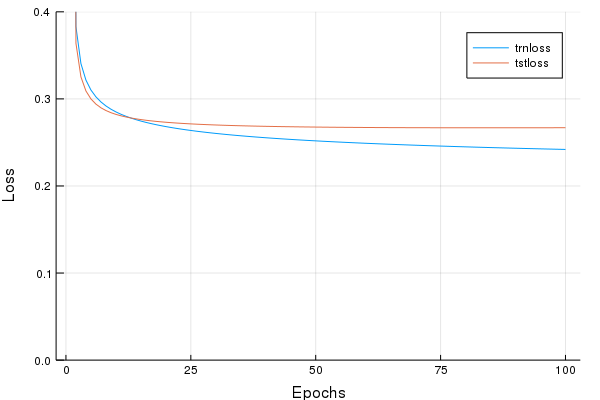

In [39]:
# Demonstrates underfitting: training loss not close to 0
# Also slight overfitting: test loss higher than train
plot([lin[2,:], lin[3,:]],ylim=(.0,.4),labels=[:trnloss :tstloss],xlabel="Epochs",ylabel="Loss")

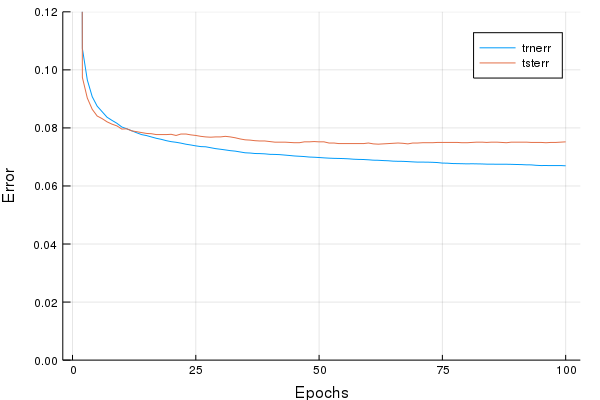

In [40]:
# this is the error plot, we get to about 7.5% test error, i.e. 92.5% accuracy
plot([lin[4,:], lin[5,:]],ylim=(.0,.12),labels=[:trnerr :tsterr],xlabel="Epochs",ylabel="Error")

## Visualizing the learned weights

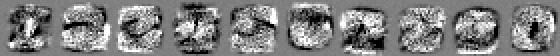

"Epoch 100"

In [41]:
# Let us visualize the evolution of the weight matrix as images below
# Each row is turned into a 28x28 image with positive weights light and negative weights dark gray
using Images, ImageMagick
for t in 10 .^ range(0,stop=log10(size(lin,2)),length=10) #logspace(0,2,20)
    i = floor(Int,t)
    f = lin[1,i]
    w1 = reshape(Array(value(f.w))', (28,28,1,10))
    w2 = clamp.(w1.+0.5,0,1)
    IJulia.clear_output(true)
    display(hcat([mnistview(w2,i) for i=1:10]...))
    display("Epoch $i")
    sleep(1) # (0.96^i)
end